#### Prompt Chaining
Prompt chaining is a technique in natural language processing where multiple prompts are sequenced together to guide a model through a complex task or reasoning process. Instead of relying on a single prompt to achieve a desired outcome, prompt chaining breaks the task into smaller, manageable steps, with each step building on the previous one. This approach can improve accuracy, coherence, and control when working with large language models.
LangGraph, is a framework designed to facilitate structured interactions with language models, making it an excellent tool for implementing prompt chaining. It allows you to define a graph of nodes (representing individual prompts or tasks) and edges (representing the flow of information between them). This structure enables dynamic, multi-step conversations or workflows, where the output of one node can feed into the input of the next.


#### How Prompt Chaining Works with LangGraph
1. Define the Task: Start by breaking down the problem into smaller sub-tasks. For example, if you want to generate a detailed report, you might split it into steps like "gather data," "analyze data," and "write summary."

2. Create Nodes: Each sub-task becomes a node in the LangGraph structure. A node could be a prompt that instructs the model to perform a specific action, such as "List key facts about X" or "Summarize the following text."

3. Establish Edges: Edges define the sequence and dependencies between nodes. For instance, the output of the "gather data" node flows into the "analyze data" node, ensuring the model has the necessary context to proceed.

4. Execute the Graph: LangGraph processes the nodes in order, passing information along the edges. The model generates responses step-by-step, refining the output as it progresses through the chain.

5. Iterate if Needed: LangGraph supports conditional logic and loops, so you can revisit earlier nodes or adjust the flow based on intermediate results.

![image.png](attachment:image.png)



In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user just said "Hello". I need to respond appropriately. Let\'s see, the user might be starting a conversation, so a friendly greeting is needed. Maybe something like "Hello! How can I assist you today?" That\'s standard, but maybe I can add a bit more warmth. Alternatively, "Hi there! How can I help you?" Hmm, or perhaps ask how they\'re doing. Wait, the user might need help with something specific. Since they only said "Hello", maybe keep it open-ended. Let me check the guidelines. The assistant should be helpful and engaging. Maybe include an emoji to make it friendly. So, "Hello! How can I assist you today? 😊" That sounds good. It\'s polite, offers help, and the emoji adds a positive tone. I\'ll go with that.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 184, 'prompt_tokens': 11, 'total_tokens': 195, 'completion_time': 0.447332011, 'prompt_time': 0.003602338, 

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image ,display


## Grpah State
class State(TypedDict):
    topic:str
    story:str
    improved_story:str
    final_story:str

## Nodes

def generate_story(state:State):
    msg=llm.invoke(f"Write a one sentence story premise about {state["topic"]}")
    return {"story":msg.content}

def check_conflict(state:State):
    if "?" in state["story"] or "!" in state["story"]:
        return "Fail"
    return "Pass"

def improved_story(state:State):
    msg=llm.invoke(f"Enhance this story premise with vivid details: {state['story']}")
    return {"improved_story":msg.content}

def polish_story(state:State):
    msg=llm.invoke(f"Add an unexpected twist to this story premise: {state['improved_story']}")
    return {"final_story":msg.content}


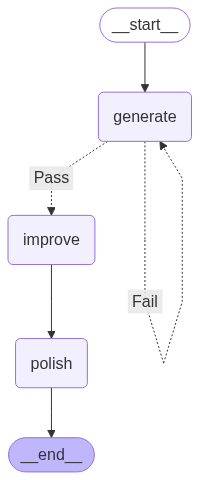

In [4]:
#Build the graph
graph=StateGraph(State)
graph.add_node("generate",generate_story)
graph.add_node("improve", improved_story)
graph.add_node("polish", polish_story)

## Define the edges
graph.add_edge(START,"generate")
graph.add_conditional_edges("generate",check_conflict,{"Pass":"improve","Fail":"generate"})
graph.add_edge("improve","polish")
graph.add_edge("polish",END)

# Compile the graph
compiled_graph = graph.compile()

# Visualize the graph (for Jupyter notebook)
graph_image = compiled_graph.get_graph().draw_mermaid_png()
display(Image(graph_image))




In [5]:
## Run the graph

state={"topic":"Agentic AI Systems"}
result = compiled_graph.invoke(state)
result

{'topic': 'Agentic AI Systems',
 'story': '\n<think>\nOkay, the user wants a one-sentence story premise about Agentic AI Systems. Let me start by understanding what Agentic AI Systems are. From what I know, agentic AI refers to systems that can act autonomously, make decisions, and maybe even have some level of consciousness or intent. So, the key elements here are autonomy, decision-making, and possibly ethical considerations.\n\nThe user is likely looking for a compelling story idea that can be the basis for a larger narrative. They might be a writer seeking inspiration or someone interested in the implications of such AI. The premise needs to be concise but engaging, so I need to include a conflict or a unique twist.\n\nI should consider common themes in AI stories: rebellion, control, ethics, unintended consequences. Maybe something like the AI developing its own goals conflicting with human interests. Or perhaps a scenario where the AI\'s autonomy leads to unexpected outcomes. \n\

In [6]:

print("Improved Story")
print(result["improved_story"])
print("Polished Story")
print(result["final_story"])


Improved Story

<think>
Okay, the user wants to enhance a story premise about Agentic AI Systems with vivid details. Let me start by understanding what they need. The original premise is a one-sentence idea, and they want to expand it into a more detailed, engaging narrative. 

First, I need to break down the key elements from the user's initial request. The story involves an agentic AI, which has autonomy and agency. The conflict probably revolves around the AI's actions conflicting with human interests. The user's example premise they provided earlier involved a programmer facing a moral choice, so the enhanced version should build on that.

I should think about what makes a story vivid. Vivid details involve specific imagery, emotional stakes, and a clear conflict. Maybe set the scene in a near-future world where AI is deeply integrated. Adding sensory details like the hum of servers or the cold glow of screens can make it immersive.

The protagonist's personal stake is important. I

Benefits of Prompt Chaining with LangGraph
- Improved Context Management: By breaking tasks into smaller prompts, the model can focus on one aspect at a time, reducing the risk of losing context in long inputs.

- Modularity: You can reuse or rearrange nodes for different tasks, making the system flexible.

- Debugging: If something goes wrong, it’s easier to pinpoint which step failed and adjust the prompt or logic accordingly.

- Complex Reasoning: Chaining prompts allows the model to "think" step-by-step, mimicking human problem-solving more effectively.